In [19]:
!pip install mysql-connector-python
!pip install pandas

"pip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"pip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [20]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

print("Создаем базу данных на SQLite...")
conn = sqlite3.connect('project_analytics.db')
cursor = conn.cursor()
print("✓ База данных project_analytics.db создана")


Создаем базу данных на SQLite...
✓ База данных project_analytics.db создана


In [21]:
# Таблица projects 
create_projects_table = """
CREATE TABLE projects (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    slug TEXT UNIQUE NOT NULL,
    timezone TEXT DEFAULT 'Europe/Moscow',
    currency TEXT DEFAULT 'RUB' CHECK(currency IN ('RUB', 'USD', 'EUR', 'KZT', 'BYN')),
    is_active BOOLEAN DEFAULT TRUE,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
"""

# Таблица yandex_counters 
create_yandex_counters_table = """
CREATE TABLE yandex_counters (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    counter_id INTEGER NOT NULL,
    name TEXT,
    is_primary BOOLEAN DEFAULT FALSE,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE,
    UNIQUE (counter_id)
)
"""

# Таблица direct_accounts 
create_direct_accounts_table = """
CREATE TABLE direct_accounts (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    client_login TEXT NOT NULL,
    account_name TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE
)
"""

# Таблица direct_campaigns 
create_direct_campaigns_table = """
CREATE TABLE direct_campaigns (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    direct_account_id INTEGER NOT NULL,
    campaign_id INTEGER NOT NULL,
    name TEXT,
    status TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (direct_account_id) REFERENCES direct_accounts(id) ON DELETE CASCADE,
    UNIQUE (direct_account_id, campaign_id)
)
"""

# Таблица goals 
create_goals_table = """
CREATE TABLE goals (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    counter_id INTEGER NOT NULL,
    goal_id INTEGER NOT NULL,
    name TEXT,
    is_conversion BOOLEAN DEFAULT FALSE,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (counter_id) REFERENCES yandex_counters(id) ON DELETE CASCADE,
    UNIQUE (counter_id, goal_id)
)
"""

# Выполняем создание таблиц
tables = [
    create_projects_table,
    create_yandex_counters_table,
    create_direct_accounts_table,
    create_direct_campaigns_table,
    create_goals_table
]

for i, table_query in enumerate(tables):
    try:
        cursor.execute(table_query)
        print(f"✓ Таблица {i+1} создана успешно")
    except Exception as e:
        print(f"✗ Ошибка при создании таблицы {i+1}: {e}")

✗ Ошибка при создании таблицы 1: table projects already exists
✗ Ошибка при создании таблицы 2: table yandex_counters already exists
✗ Ошибка при создании таблицы 3: table direct_accounts already exists
✗ Ошибка при создании таблицы 4: table direct_campaigns already exists
✗ Ошибка при создании таблицы 5: table goals already exists


In [22]:
# Проверяем, что таблицы создались
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()
print("\nСозданные таблицы:")
for table in tables:
    print(f" - {table[0]}")


Созданные таблицы:
 - projects
 - sqlite_sequence
 - yandex_counters
 - direct_accounts
 - direct_campaigns
 - goals


In [23]:
# Вставляем проекты
try:
    insert_projects = """
    INSERT OR IGNORE INTO projects (name, slug, timezone, currency, is_active) VALUES
    ('Интернет-магазин "ТехноМир"', 'technomir-store', 'Europe/Moscow', 'RUB', 1),
    ('Блог о путешествиях', 'travel-blog', 'Europe/London', 'USD', 1),
    ('Сервис доставки еды', 'food-delivery', 'Europe/Moscow', 'RUB', 0)
    """
    
    cursor.execute(insert_projects)
    print("Проекты добавлены")
except Exception as e:
    print(f"Ошибка при добавлении проектов: {e}")

# Вставляем Яндекс.Метрика счетчики
try:
    # Сначала получаем актуальные ID проектов
    cursor.execute("SELECT id FROM projects WHERE slug = 'technomir-store'")
    result = cursor.fetchone()
    project1_id = result[0] if result else 1
    
    cursor.execute("SELECT id FROM projects WHERE slug = 'travel-blog'")
    result = cursor.fetchone()
    project2_id = result[0] if result else 2
    
    cursor.execute("SELECT id FROM projects WHERE slug = 'food-delivery'")
    result = cursor.fetchone()
    project3_id = result[0] if result else 3
    
    insert_counters = """
    INSERT OR IGNORE INTO yandex_counters (project_id, counter_id, name, is_primary) VALUES
    (?, 123456789, 'Основной счетчик ТехноМир', 1),
    (?, 123456790, 'Мобильный счетчик', 0),
    (?, 987654321, 'Счетчик блога о путешествиях', 1),
    (?, 555555555, 'Счетчик доставки еды', 1)
    """
    
    cursor.execute(insert_counters, (project1_id, project1_id, project2_id, project3_id))
    print("Счетчики Яндекс.Метрики добавлены")
except Exception as e:
    print(f"Ошибка при добавлении счетчиков: {e}")

# Вставляем Директ аккаунты
try:
    # Получаем актуальные ID проектов
    cursor.execute("SELECT id FROM projects WHERE slug = 'technomir-store'")
    result = cursor.fetchone()
    project1_id = result[0] if result else 1
    
    cursor.execute("SELECT id FROM projects WHERE slug = 'travel-blog'")
    result = cursor.fetchone()
    project2_id = result[0] if result else 2
    
    insert_direct_accounts = """
    INSERT OR IGNORE INTO direct_accounts (project_id, client_login, account_name) VALUES
    (?, 'technomir-client', 'Аккаунт ТехноМир'),
    (?, 'technomir-mobile', 'Мобильные кампании'),
    (?, 'travel-blog-ads', 'Реклама блога о путешествиях')
    """
    
    cursor.execute(insert_direct_accounts, (project1_id, project1_id, project2_id))
    print("Директ аккаунты добавлены")
except Exception as e:
    print(f"Ошибка при добавлении Директ аккаунтов: {e}")

# Вставляем кампании Директа
try:
    # Получаем актуальные ID аккаунтов
    cursor.execute("SELECT id FROM direct_accounts WHERE client_login = 'technomir-client'")
    result = cursor.fetchone()
    account1_id = result[0] if result else 1
    
    cursor.execute("SELECT id FROM direct_accounts WHERE client_login = 'technomir-mobile'")
    result = cursor.fetchone()
    account2_id = result[0] if result else 2
    
    cursor.execute("SELECT id FROM direct_accounts WHERE client_login = 'travel-blog-ads'")
    result = cursor.fetchone()
    account3_id = result[0] if result else 3
    
    insert_campaigns = """
    INSERT OR IGNORE INTO direct_campaigns (direct_account_id, campaign_id, name, status) VALUES
    (?, 10001, 'Кампания - Товары для дома', 'ACTIVE'),
    (?, 10002, 'Кампания - Электроника', 'PAUSED'),
    (?, 20001, 'Мобильная кампания', 'ACTIVE'),
    (?, 30001, 'Кампания - Статьи о путешествиях', 'ACTIVE')
    """
    
    cursor.execute(insert_campaigns, (account1_id, account1_id, account2_id, account3_id))
    print("Кампании Директа добавлены")
except Exception as e:
    print(f"Ошибка при добавлении кампаний: {e}")

# Вставляем цели
try:
    # Получаем актуальные ID счетчиков
    cursor.execute("SELECT id FROM yandex_counters WHERE counter_id = 123456789")
    result = cursor.fetchone()
    counter1_id = result[0] if result else 1
    
    cursor.execute("SELECT id FROM yandex_counters WHERE counter_id = 987654321")
    result = cursor.fetchone()
    counter3_id = result[0] if result else 3
    
    insert_goals = """
    INSERT OR IGNORE INTO goals (counter_id, goal_id, name, is_conversion) VALUES
    (?, 101, 'Заказ товара', 1),
    (?, 102, 'Добавление в корзину', 0),
    (?, 103, 'Просмотр контактов', 1),
    (?, 201, 'Подписка на рассылку', 1),
    (?, 202, 'Комментарий к статье', 0)
    """
    
    cursor.execute(insert_goals, (counter1_id, counter1_id, counter1_id, counter3_id, counter3_id))
    print("Цели добавлены")
except Exception as e:
    print(f"Ошибка при добавлении целей: {e}")

# Фиксируем изменения
try:
    conn.commit()
    print("✓ Все изменения успешно сохранены в базе данных")
except Exception as e:
    print(f"Ошибка при сохранении изменений: {e}")
    conn.rollback()

Ошибка при добавлении проектов: database is locked
Ошибка при добавлении счетчиков: database is locked
Ошибка при добавлении Директ аккаунтов: database is locked
Ошибка при добавлении кампаний: database is locked
Ошибка при добавлении целей: database is locked
✓ Все изменения успешно сохранены в базе данных


In [24]:
def execute_query_to_dataframe(query, description):
    """Выполняет запрос и возвращает результат в виде DataFrame"""
    cursor.execute(query)
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(result, columns=columns)
    print(f"\n=== {description} ===")
    print(f"Количество записей: {len(df)}")
    return df

# Проверяем проекты
projects_df = execute_query_to_dataframe("SELECT * FROM projects", "ПРОЕКТЫ")
print(projects_df)

# Проверяем счетчики
counters_df = execute_query_to_dataframe("SELECT * FROM yandex_counters", "ЯНДЕКС.МЕТРИКА СЧЕТЧИКИ")
print(counters_df)

# Проверяем Директ аккаунты
accounts_df = execute_query_to_dataframe("SELECT * FROM direct_accounts", "ДИРЕКТ АККАУНТЫ")
print(accounts_df)

# Проверяем кампании
campaigns_df = execute_query_to_dataframe("SELECT * FROM direct_campaigns", "ДИРЕКТ КАМПАНИИ")
print(campaigns_df)

# Проверяем цели
goals_df = execute_query_to_dataframe("SELECT * FROM goals", "ЦЕЛИ")
print(goals_df)


=== ПРОЕКТЫ ===
Количество записей: 3
   id                         name             slug       timezone currency  \
0   1  Интернет-магазин "ТехноМир"  technomir-store  Europe/Moscow      RUB   
1   2          Блог о путешествиях      travel-blog  Europe/London      USD   
2   3          Сервис доставки еды    food-delivery  Europe/Moscow      RUB   

   is_active           created_at           updated_at  
0          1  2025-11-14 20:52:27  2025-11-14 20:52:27  
1          1  2025-11-14 20:52:27  2025-11-14 20:52:27  
2          0  2025-11-14 20:52:27  2025-11-14 20:52:27  

=== ЯНДЕКС.МЕТРИКА СЧЕТЧИКИ ===
Количество записей: 4
   id  project_id  counter_id                          name  is_primary  \
0   1           1   123456789     Основной счетчик ТехноМир           1   
1   2           1   123456790             Мобильный счетчик           0   
2   3           2   987654321  Счетчик блога о путешествиях           1   
3   4           3   555555555          Счетчик доставки еды  

# Закрытие соединения

print("\n" + "="*50)
print("ЗАКРЫТИЕ СОЕДИНЕНИЯ")
print("="*50)

# Проверяем тип базы данных
if isinstance(conn, mysql.connector.MySQLConnection):
    print("Тип базы: MySQL")
    if conn.is_connected():
        cursor.close()
        conn.close()
        print("✓ MySQL соединение закрыто")
    else:
        print("Соединение уже закрыто")
else:
    print("Тип базы: SQLite")
    try:
        cursor.close()
        conn.close()
        print("✓ SQLite соединение закрыто")
    except:
        print("Соединение уже закрыто")

print("Работа с базой данных завершена!")

import sqlite3
import pandas as pd

# Открываем соединение
def open_sqlite_connection():
    try:
        conn = sqlite3.connect('project_analytics.db')
        cursor = conn.cursor()
        print("✓ Соединение с SQLite открыто")
        return conn, cursor
    except Exception as e:
        print(f"✗ Ошибка подключения: {e}")
        return None, None

# Используем
conn, cursor = open_sqlite_connection()

if conn:
    print("Готово к работе с данными!")

In [25]:
def safe_insert_project(name, slug):
    """Безопасное добавление проекта с проверкой уникальности"""
    try:
        # Сначала проверяем существует ли slug
        cursor.execute("SELECT COUNT(*) FROM projects WHERE slug = ?", (slug,))
        count = cursor.fetchone()[0]
        
        if count > 0:
            print(f"⚠️  Slug '{slug}' уже существует. Выберите другой.")
            return False
        
        # Если slug свободен - добавляем
        cursor.execute(
            "INSERT INTO projects (name, slug) VALUES (?, ?)", 
            (name, slug)
        )
        conn.commit()
        print(f"✓ Проект '{name}' успешно добавлен с slug '{slug}'")
        return True
        
    except Exception as e:
        print(f"✗ Ошибка при добавлении проекта: {e}")
        return False

# Тестируем безопасное добавление
print("\n=== БЕЗОПАСНОЕ ДОБАВЛЕНИЕ ===")
safe_insert_project("Тестовый проект 1", "unique-test-1")  # Должно сработать
safe_insert_project("Тестовый проект 2", "technomir-store")  # Должно отказать
safe_insert_project("Тестовый проект 3", "unique-test-2")  # Должно сработать


=== БЕЗОПАСНОЕ ДОБАВЛЕНИЕ ===
✗ Ошибка при добавлении проекта: database is locked
⚠️  Slug 'technomir-store' уже существует. Выберите другой.
✗ Ошибка при добавлении проекта: database is locked


False

import sqlite3
import os
import shutil

# Ваша текущая база данных
db_file = 'project_analytics.db'

# Просто скопируйте файл базы данных
def backup_sqlite_database():
    backup_file = 'project_analytics_backup.db'
    
    # Закрываем соединение если открыто
    try:
        if 'conn' in locals():
            conn.close()
    except:
        pass
    
    # Копируем файл
    shutil.copy2(db_file, backup_file)
    print(f"✓ База данных сохранена в файл: {backup_file}")
    print(f"✓ Размер файла: {os.path.getsize(backup_file)} байт")
    return backup_file

# Создаем backup
backup_file = backup_sqlite_database()

In [26]:
# Таблицы для хранилища агрегатов (помесячно)

# 1. metrics_monthly - общие метрики Метрики по проекту
create_metrics_monthly_table = """
CREATE TABLE metrics_monthly (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    month INTEGER NOT NULL CHECK(month >= 1 AND month <= 12),
    visits INTEGER DEFAULT 0,
    users INTEGER DEFAULT 0,
    bounce_rate DECIMAL(5,2) DEFAULT 0.0,
    avg_session_duration_sec INTEGER DEFAULT 0,
    conversions INTEGER,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE,
    UNIQUE (project_id, year, month)
)
"""

# 2. metrics_age_monthly - разбивка по возрасту
create_metrics_age_monthly_table = """
CREATE TABLE metrics_age_monthly (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    month INTEGER NOT NULL CHECK(month >= 1 AND month <= 12),
    age_group TEXT CHECK(age_group IN ('18-24', '25-34', '35-44', '45-54', '55+', 'unknown')),
    visits INTEGER DEFAULT 0,
    users INTEGER DEFAULT 0,
    bounce_rate DECIMAL(5,2) DEFAULT 0.0,
    avg_session_duration_sec INTEGER DEFAULT 0,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE,
    UNIQUE (project_id, year, month, age_group)
)
"""

# 3. direct_campaign_monthly - агрегаты Директа по кампаниям
create_direct_campaign_monthly_table = """
CREATE TABLE direct_campaign_monthly (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    direct_campaign_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    month INTEGER NOT NULL CHECK(month >= 1 AND month <= 12),
    impressions INTEGER DEFAULT 0,
    clicks INTEGER DEFAULT 0,
    ctr_pct DECIMAL(6,2) DEFAULT 0.0,
    cpc DECIMAL(12,2) DEFAULT 0.0,
    conversions INTEGER,
    cpa DECIMAL(12,2),
    cost DECIMAL(14,2) DEFAULT 0.0,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE,
    FOREIGN KEY (direct_campaign_id) REFERENCES direct_campaigns(id) ON DELETE CASCADE,
    UNIQUE (direct_campaign_id, year, month)
)
"""

# 4. direct_totals_monthly - итоги по всем кампаниям проекта
create_direct_totals_monthly_table = """
CREATE TABLE direct_totals_monthly (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    month INTEGER NOT NULL CHECK(month >= 1 AND month <= 12),
    impressions INTEGER DEFAULT 0,
    clicks INTEGER DEFAULT 0,
    ctr_pct DECIMAL(6,2) DEFAULT 0.0,
    cpc DECIMAL(12,2) DEFAULT 0.0,
    conversions INTEGER,
    cpa DECIMAL(12,2),
    cost DECIMAL(14,2) DEFAULT 0.0,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE,
    UNIQUE (project_id, year, month)
)
"""

# 5. seo_queries_monthly - позиции по SEO запросам
create_seo_queries_monthly_table = """
CREATE TABLE seo_queries_monthly (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    project_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    month INTEGER NOT NULL CHECK(month >= 1 AND month <= 12),
    query TEXT NOT NULL,
    position INTEGER,
    url TEXT,
    
    FOREIGN KEY (project_id) REFERENCES projects(id) ON DELETE CASCADE,
    UNIQUE (project_id, year, month, query)
)
"""

# Создаем таблицы агрегатов
aggregate_tables = [
    create_metrics_monthly_table,
    create_metrics_age_monthly_table,
    create_direct_campaign_monthly_table,
    create_direct_totals_monthly_table,
    create_seo_queries_monthly_table
]

print("=== СОЗДАНИЕ ТАБЛИЦ ХРАНИЛИЩА АГРЕГАТОВ ===")
for i, table_query in enumerate(aggregate_tables):
    try:
        cursor.execute(table_query)
        print(f"✓ Таблица агрегатов {i+1} создана успешно")
    except Exception as e:
        print(f"✗ Ошибка при создании таблицы агрегатов {i+1}: {e}")

=== СОЗДАНИЕ ТАБЛИЦ ХРАНИЛИЩА АГРЕГАТОВ ===
✗ Ошибка при создании таблицы агрегатов 1: database is locked
✗ Ошибка при создании таблицы агрегатов 2: database is locked
✗ Ошибка при создании таблицы агрегатов 3: database is locked
✗ Ошибка при создании таблицы агрегатов 4: database is locked
✗ Ошибка при создании таблицы агрегатов 5: database is locked


In [27]:
# Индексы для таблиц агрегатов
aggregate_indexes = [
    # metrics_monthly
    "CREATE INDEX idx_metrics_monthly_project_date ON metrics_monthly(project_id, year, month)",
    "CREATE INDEX idx_metrics_monthly_date ON metrics_monthly(year, month)",
    
    # metrics_age_monthly
    "CREATE INDEX idx_metrics_age_monthly_project_date ON metrics_age_monthly(project_id, year, month)",
    "CREATE INDEX idx_metrics_age_monthly_age ON metrics_age_monthly(age_group)",
    
    # direct_campaign_monthly
    "CREATE INDEX idx_direct_campaign_monthly_project ON direct_campaign_monthly(project_id)",
    "CREATE INDEX idx_direct_campaign_monthly_campaign ON direct_campaign_monthly(direct_campaign_id)",
    "CREATE INDEX idx_direct_campaign_monthly_date ON direct_campaign_monthly(year, month)",
    
    # direct_totals_monthly
    "CREATE INDEX idx_direct_totals_monthly_project_date ON direct_totals_monthly(project_id, year, month)",
    
    # seo_queries_monthly
    "CREATE INDEX idx_seo_queries_monthly_project_date ON seo_queries_monthly(project_id, year, month)",
    "CREATE INDEX idx_seo_queries_monthly_query ON seo_queries_monthly(query)",
    "CREATE INDEX idx_seo_queries_monthly_position ON seo_queries_monthly(position)"
]

print("\n=== СОЗДАНИЕ ИНДЕКСОВ ДЛЯ АГРЕГАТОВ ===")
for i, index_query in enumerate(aggregate_indexes):
    try:
        cursor.execute(index_query)
        print(f"✓ Индекс {i+1} создан успешно")
    except Exception as e:
        print(f"✗ Ошибка при создании индекса {i+1}: {e}")


=== СОЗДАНИЕ ИНДЕКСОВ ДЛЯ АГРЕГАТОВ ===
✗ Ошибка при создании индекса 1: no such table: main.metrics_monthly
✗ Ошибка при создании индекса 2: no such table: main.metrics_monthly
✗ Ошибка при создании индекса 3: no such table: main.metrics_age_monthly
✗ Ошибка при создании индекса 4: no such table: main.metrics_age_monthly
✗ Ошибка при создании индекса 5: no such table: main.direct_campaign_monthly
✗ Ошибка при создании индекса 6: no such table: main.direct_campaign_monthly
✗ Ошибка при создании индекса 7: no such table: main.direct_campaign_monthly
✗ Ошибка при создании индекса 8: no such table: main.direct_totals_monthly
✗ Ошибка при создании индекса 9: no such table: main.seo_queries_monthly
✗ Ошибка при создании индекса 10: no such table: main.seo_queries_monthly
✗ Ошибка при создании индекса 11: no such table: main.seo_queries_monthly


In [28]:
# Добавляем тестовые данные в таблицы агрегатов
print("\n=== ДОБАВЛЕНИЕ ТЕСТОВЫХ ДАННЫХ В АГРЕГАТЫ ===")

# Сначала проверяем существование таблиц
def table_exists(table_name):
    """Проверяет существование таблицы"""
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,))
    return cursor.fetchone() is not None

# Получаем актуальные ID проектов
try:
    cursor.execute("SELECT id FROM projects WHERE slug = 'technomir-store'")
    result = cursor.fetchone()
    project1_id = result[0] if result else None
    
    cursor.execute("SELECT id FROM projects WHERE slug = 'travel-blog'")
    result = cursor.fetchone()
    project2_id = result[0] if result else None
    
    if not project1_id or not project2_id:
        print("⚠️  Ошибка: не найдены необходимые проекты в базе данных")
        print("   Убедитесь, что проекты были добавлены в Cell 4")
    else:
        print(f"✓ Найдены проекты: ID {project1_id} (ТехноМир), ID {project2_id} (Блог о путешествиях)")
except Exception as e:
    print(f"✗ Ошибка при получении ID проектов: {e}")
    project1_id = None
    project2_id = None

# Получаем актуальные ID кампаний Директа
campaign_ids = {}
try:
    # Получаем ID кампаний по их названиям
    cursor.execute("SELECT id FROM direct_campaigns WHERE name = 'Кампания - Товары для дома'")
    result = cursor.fetchone()
    campaign_ids['tovary'] = result[0] if result else None
    
    cursor.execute("SELECT id FROM direct_campaigns WHERE name = 'Кампания - Электроника'")
    result = cursor.fetchone()
    campaign_ids['elektronika'] = result[0] if result else None
    
    cursor.execute("SELECT id FROM direct_campaigns WHERE name = 'Мобильная кампания'")
    result = cursor.fetchone()
    campaign_ids['mobile'] = result[0] if result else None
    
    cursor.execute("SELECT id FROM direct_campaigns WHERE name = 'Кампания - Статьи о путешествиях'")
    result = cursor.fetchone()
    campaign_ids['travel'] = result[0] if result else None
    
    print(f"✓ Найдены кампании: {campaign_ids}")
except Exception as e:
    print(f"⚠️  Ошибка при получении ID кампаний: {e}")

# 1. Данные для metrics_monthly
if table_exists('metrics_monthly') and project1_id and project2_id:
    try:
        insert_metrics_monthly = """
        INSERT OR IGNORE INTO metrics_monthly (project_id, year, month, visits, users, bounce_rate, avg_session_duration_sec, conversions) VALUES
        (?, 2024, 1, 15000, 12000, 45.50, 180, 350),
        (?, 2024, 2, 16500, 13000, 42.30, 195, 420),
        (?, 2024, 1, 8000, 6500, 52.10, 120, 150),
        (?, 2023, 12, 14000, 11000, 48.20, 165, 300)
        """
        cursor.execute(insert_metrics_monthly, (project1_id, project1_id, project2_id, project1_id))
        conn.commit()
        print("✓ Тестовые данные добавлены в metrics_monthly")
    except Exception as e:
        print(f"✗ Ошибка при добавлении данных в metrics_monthly: {e}")
else:
    print("⚠️  Пропущена вставка в metrics_monthly (таблица не существует или отсутствуют проекты)")

# 2. Данные для metrics_age_monthly
if table_exists('metrics_age_monthly') and project1_id:
    try:
        insert_metrics_age_monthly = """
        INSERT OR IGNORE INTO metrics_age_monthly (project_id, year, month, age_group, visits, users, bounce_rate, avg_session_duration_sec) VALUES
        (?, 2024, 1, '18-24', 3000, 2500, 55.20, 150),
        (?, 2024, 1, '25-34', 6000, 4800, 40.10, 210),
        (?, 2024, 1, '35-44', 4000, 3200, 38.50, 195),
        (?, 2024, 1, '45-54', 1500, 1200, 42.30, 180),
        (?, 2024, 1, '55+', 500, 400, 50.10, 160),
        (?, 2024, 1, 'unknown', 0, 0, 0.0, 0)
        """
        cursor.execute(insert_metrics_age_monthly, (project1_id, project1_id, project1_id, project1_id, project1_id, project1_id))
        conn.commit()
        print("✓ Тестовые данные добавлены в metrics_age_monthly")
    except Exception as e:
        print(f"✗ Ошибка при добавлении данных в metrics_age_monthly: {e}")
else:
    print("⚠️  Пропущена вставка в metrics_age_monthly (таблица не существует или отсутствуют проекты)")

# 3. Данные для direct_campaign_monthly
if table_exists('direct_campaign_monthly') and project1_id and project2_id and all(campaign_ids.values()):
    try:
        insert_direct_campaign_monthly = """
        INSERT OR IGNORE INTO direct_campaign_monthly (project_id, direct_campaign_id, year, month, impressions, clicks, ctr_pct, cpc, conversions, cpa, cost) VALUES
        (?, ?, 2024, 1, 50000, 2500, 5.00, 12.50, 120, 260.42, 31250.00),
        (?, ?, 2024, 1, 30000, 1200, 4.00, 15.75, 80, 236.25, 18900.00),
        (?, ?, 2024, 1, 25000, 1800, 7.20, 8.90, 95, 168.42, 16020.00),
        (?, ?, 2024, 1, 15000, 800, 5.33, 10.25, 45, 182.22, 8200.00)
        """
        cursor.execute(insert_direct_campaign_monthly, (
            project1_id, campaign_ids['tovary'],
            project1_id, campaign_ids['elektronika'],
            project1_id, campaign_ids['mobile'],
            project2_id, campaign_ids['travel']
        ))
        conn.commit()
        print("✓ Тестовые данные добавлены в direct_campaign_monthly")
    except Exception as e:
        print(f"✗ Ошибка при добавлении данных в direct_campaign_monthly: {e}")
else:
    print("⚠️  Пропущена вставка в direct_campaign_monthly (таблица не существует или отсутствуют проекты/кампании)")

# 4. Данные для direct_totals_monthly
if table_exists('direct_totals_monthly') and project1_id and project2_id:
    try:
        insert_direct_totals_monthly = """
        INSERT OR IGNORE INTO direct_totals_monthly (project_id, year, month, impressions, clicks, ctr_pct, cpc, conversions, cpa, cost) VALUES
        (?, 2024, 1, 105000, 5500, 5.24, 12.05, 295, 224.24, 66170.00),
        (?, 2024, 1, 15000, 800, 5.33, 10.25, 45, 182.22, 8200.00),
        (?, 2023, 12, 95000, 4800, 5.05, 11.80, 270, 210.37, 56640.00)
        """
        cursor.execute(insert_direct_totals_monthly, (project1_id, project2_id, project1_id))
        conn.commit()
        print("✓ Тестовые данные добавлены в direct_totals_monthly")
    except Exception as e:
        print(f"✗ Ошибка при добавлении данных в direct_totals_monthly: {e}")
else:
    print("⚠️  Пропущена вставка в direct_totals_monthly (таблица не существует или отсутствуют проекты)")

# 5. Данные для seo_queries_monthly
if table_exists('seo_queries_monthly') and project1_id and project2_id:
    try:
        insert_seo_queries_monthly = """
        INSERT OR IGNORE INTO seo_queries_monthly (project_id, year, month, query, position, url) VALUES
        (?, 2024, 1, 'купить ноутбук', 3, 'https://technomir.ru/laptops'),
        (?, 2024, 1, 'игровой компьютер', 5, 'https://technomir.ru/gaming-pc'),
        (?, 2024, 1, 'смартфон цена', 8, 'https://technomir.ru/smartphones'),
        (?, 2024, 1, 'лучшие места для путешествий', 2, 'https://travelblog.ru/top-destinations'),
        (?, 2024, 1, 'советы туристам', 4, 'https://travelblog.ru/tips'),
        (?, 2024, 2, 'купить ноутбук', 2, 'https://technomir.ru/laptops'),
        (?, 2024, 2, 'игровой компьютер', 4, 'https://technomir.ru/gaming-pc')
        """
        cursor.execute(insert_seo_queries_monthly, (
            project1_id, project1_id, project1_id,
            project2_id, project2_id,
            project1_id, project1_id
        ))
        conn.commit()
        print("✓ Тестовые данные добавлены в seo_queries_monthly")
    except Exception as e:
        print(f"✗ Ошибка при добавлении данных в seo_queries_monthly: {e}")
else:
    print("⚠️  Пропущена вставка в seo_queries_monthly (таблица не существует или отсутствуют проекты)")

print("\n✓ Завершено добавление тестовых данных в агрегаты")


=== ДОБАВЛЕНИЕ ТЕСТОВЫХ ДАННЫХ В АГРЕГАТЫ ===
✓ Найдены проекты: ID 1 (ТехноМир), ID 2 (Блог о путешествиях)
✓ Найдены кампании: {'tovary': 1, 'elektronika': 2, 'mobile': 3, 'travel': 4}
⚠️  Пропущена вставка в metrics_monthly (таблица не существует или отсутствуют проекты)
⚠️  Пропущена вставка в metrics_age_monthly (таблица не существует или отсутствуют проекты)
⚠️  Пропущена вставка в direct_campaign_monthly (таблица не существует или отсутствуют проекты/кампании)
⚠️  Пропущена вставка в direct_totals_monthly (таблица не существует или отсутствуют проекты)
⚠️  Пропущена вставка в seo_queries_monthly (таблица не существует или отсутствуют проекты)

✓ Завершено добавление тестовых данных в агрегаты


In [29]:
# Проверяем созданные таблицы агрегатов
print("\n=== ПРОВЕРКА СОЗДАННЫХ ТАБЛИЦ АГРЕГАТОВ ===")

aggregate_tables_to_check = [
    'metrics_monthly',
    'metrics_age_monthly', 
    'direct_campaign_monthly',
    'direct_totals_monthly',
    'seo_queries_monthly'
]

for table in aggregate_tables_to_check:
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {table}")
        count = cursor.fetchone()[0]
        print(f"✓ {table}: {count} записей")
    except Exception as e:
        print(f"✗ {table}: ошибка - {e}")


=== ПРОВЕРКА СОЗДАННЫХ ТАБЛИЦ АГРЕГАТОВ ===
✗ metrics_monthly: ошибка - no such table: metrics_monthly
✗ metrics_age_monthly: ошибка - no such table: metrics_age_monthly
✗ direct_campaign_monthly: ошибка - no such table: direct_campaign_monthly
✗ direct_totals_monthly: ошибка - no such table: direct_totals_monthly
✗ seo_queries_monthly: ошибка - no such table: seo_queries_monthly


import sqlite3
import pandas as pd
import shutil
import os
from datetime import datetime

def save_database_to_file():
    """Сохраняет всю базу данных в несколько форматов"""
    
    print("=== СОХРАНЕНИЕ БАЗЫ ДАННЫХ В ФАЙЛ ===")
    
    # Создаем папку для backup
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_folder = f"project_analytics_backup_{timestamp}"
    os.makedirs(backup_folder, exist_ok=True)
    
    # Подключаемся к базе
    conn = sqlite3.connect('project_analytics.db')
    
    # 1. Сохраняем исходный файл SQLite
    original_db = os.path.join(backup_folder, 'project_analytics.db')
    shutil.copy2('project_analytics.db', original_db)
    print(f"✓ 1. Файл SQLite сохранен: {original_db}")
    
    # 2. Создаем SQL дамп
    sql_dump_file = create_sql_dump(conn, backup_folder)
    
    # 3. Создаем Excel файл со всеми таблицами
    excel_file = create_excel_export(conn, backup_folder)
    
    # 4. Создаем CSV файлы
    csv_zip_file = create_csv_export(conn, backup_folder)
    
    # 5. Создаем отчет в PDF (текстовый)
    create_readme_report(conn, backup_folder)
    
    # 6. Создаем ZIP архив со всем содержимым
    zip_file = create_final_zip(backup_folder)
    
    conn.close()
    
    # Показываем итоги
    print_summary(zip_file)
    
    return zip_file

def create_sql_dump(conn, backup_folder):
    """Создает SQL дамп всей базы данных"""
    sql_dump_file = os.path.join(backup_folder, 'project_analytics_dump.sql')
    
    cursor = conn.cursor()
    
    with open(sql_dump_file, 'w', encoding='utf-8') as f:
        f.write("-- SQL Dump of Project Analytics Database\n")
        f.write(f"-- Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("-- Database: SQLite\n\n")
        
        # Получаем все таблицы
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name")
        tables = cursor.fetchall()
        
        for table in tables:
            table_name = table[0]
            
            # Записываем структуру таблицы
            cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}'")
            create_sql = cursor.fetchone()[0]
            f.write(f"{create_sql};\n\n")
            
            # Записываем данные
            cursor.execute(f"SELECT * FROM {table_name}")
            rows = cursor.fetchall()
            
            if rows:
                # Получаем названия колонок
                cursor.execute(f"PRAGMA table_info({table_name})")
                columns = [col[1] for col in cursor.fetchall()]
                
                for row in rows:
                    values = []
                    for value in row:
                        if value is None:
                            values.append('NULL')
                        elif isinstance(value, str):
                            # Экранируем кавычки
                            escaped_value = value.replace("'", "''")
                            values.append(f"'{escaped_value}'")
                        elif isinstance(value, bool):
                            values.append('1' if value else '0')
                        elif isinstance(value, (int, float)):
                            values.append(str(value))
                        else:
                            values.append(f"'{str(value)}'")
                    
                    insert_sql = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES ({', '.join(values)});"
                    f.write(insert_sql + "\n")
            
            f.write("\n" + "-" * 80 + "\n\n")
    
    print(f"✓ 2. SQL дамп создан: {sql_dump_file}")
    return sql_dump_file

def create_excel_export(conn, backup_folder):
    """Создает Excel файл со всеми таблицами"""
    excel_file = os.path.join(backup_folder, 'project_analytics.xlsx')
    
    # Получаем список таблиц
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name")
    tables = [table[0] for table in cursor.fetchall()]
    
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        for table in tables:
            try:
                df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
                # Ограничиваем длину названия листа (Excel ограничение 31 символ)
                sheet_name = table[:31]
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            except Exception as e:
                print(f"   ⚠️  Ошибка при экспорте таблицы {table}: {e}")
    
    print(f"✓ 3. Excel файл создан: {excel_file}")
    return excel_file

def create_csv_export(conn, backup_folder):
    """Создает CSV файлы для каждой таблицы"""
    csv_folder = os.path.join(backup_folder, 'csv_files')
    os.makedirs(csv_folder, exist_ok=True)
    
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name")
    tables = [table[0] for table in cursor.fetchall()]
    
    for table in tables:
        try:
            df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
            csv_file = os.path.join(csv_folder, f'{table}.csv')
            df.to_csv(csv_file, index=False, encoding='utf-8')
        except Exception as e:
            print(f"   ⚠️  Ошибка при создании CSV для {table}: {e}")
    
    # Создаем ZIP архив с CSV файлами
    import zipfile
    csv_zip_file = os.path.join(backup_folder, 'project_analytics_csv.zip')
    with zipfile.ZipFile(csv_zip_file, 'w') as zipf:
        for root, dirs, files in os.walk(csv_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.basename(file_path))
    
    # Удаляем временную папку CSV
    shutil.rmtree(csv_folder)
    
    print(f"✓ 4. CSV архив создан: {csv_zip_file}")
    return csv_zip_file

def create_readme_report(conn, backup_folder):
    """Создает README файл с информацией о базе данных"""
    readme_file = os.path.join(backup_folder, 'README.txt')
    
    cursor = conn.cursor()
    
    # Собираем статистику по таблицам
    table_stats = []
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name")
    tables = cursor.fetchall()
    
    for table in tables:
        table_name = table[0]
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        count = cursor.fetchone()[0]
        table_stats.append((table_name, count))
    
    with open(readme_file, 'w', encoding='utf-8') as f:
        f.write("PROJECT ANALYTICS DATABASE BACKUP\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Дата создания: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("СОДЕРЖИМОЕ АРХИВА:\n")
        f.write("1. project_analytics.db      - Файл базы данных SQLite\n")
        f.write("2. project_analytics_dump.sql - Полный SQL дамп базы\n")
        f.write("3. project_analytics.xlsx    - Данные в формате Excel\n")
        f.write("4. project_analytics_csv.zip - Данные в формате CSV\n")
        f.write("5. README.txt                - Этот файл\n\n")
        
        f.write("СТАТИСТИКА БАЗЫ ДАННЫХ:\n")
        f.write("-" * 30 + "\n")
        for table_name, count in table_stats:
            f.write(f"{table_name:<25} : {count:>6} записей\n")
        
        f.write(f"\nВсего таблиц: {len(table_stats)}\n")
        f.write(f"Всего записей: {sum(count for _, count in table_stats)}\n\n")
        
        f.write("ОПИСАНИЕ ТАБЛИЦ:\n")
        f.write("-" * 30 + "\n")
        f.write("projects              - Основные проекты\n")
        f.write("yandex_counters       - Счетчики Яндекс.Метрики\n")
        f.write("direct_accounts       - Аккаунты Яндекс.Директ\n")
        f.write("direct_campaigns      - Рекламные кампании\n")
        f.write("goals                 - Цели веб-аналитики\n")
        f.write("metrics_monthly       - Помесячные метрики\n")
        f.write("metrics_age_monthly   - Метрики по возрастам\n")
        f.write("direct_campaign_monthly - Статистика кампаний\n")
        f.write("direct_totals_monthly - Итоги по Директу\n")
        f.write("seo_queries_monthly   - SEO позиции\n\n")
        
        f.write("ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:\n")
        f.write("-" * 30 + "\n")
        f.write("1. Для просмотра данных: откройте Excel файл\n")
        f.write("2. Для работы с БД: используйте SQLite файл\n")
        f.write("3. Для импорта в другую БД: используйте SQL дамп\n")
        f.write("4. Для программирования: используйте CSV файлы\n\n")
        
        f.write("СОЗДАНО АВТОМАТИЧЕСКИ\n")

    print(f"✓ 5. README файл создан: {readme_file}")
    return readme_file

def create_final_zip(backup_folder):
    """Создает финальный ZIP архив"""
    zip_file = f"{backup_folder}.zip"
    shutil.make_archive(backup_folder, 'zip', backup_folder)
    
    # Удаляем временную папку
    shutil.rmtree(backup_folder)
    
    print(f"✓ 6. Финальный ZIP архив создан: {zip_file}")
    return zip_file

def print_summary(zip_file):
    """Показывает итоговую информацию"""
    file_size = os.path.getsize(zip_file)
    file_size_mb = file_size / (1024 * 1024)
    
    print("\n" + "=" * 60)
    print("✅ БАЗА ДАННЫХ УСПЕШНО СОХРАНЕНА!")
    print("=" * 60)
    print(f"📁 Файл: {zip_file}")
    print(f"📊 Размер: {file_size_mb:.2f} MB")
    print(f"🕐 Время: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("\n📋 Содержимое архива:")
    print("   • project_analytics.db      - SQLite база данных")
    print("   • project_analytics_dump.sql - SQL дамп")
    print("   • project_analytics.xlsx    - Excel с данными")
    print("   • project_analytics_csv.zip - CSV файлы")
    print("   • README.txt                - Описание")
    print("\n📤 Теперь вы можете отправить этот файл другому человеку!")
    print("=" * 60)

# Запускаем сохранение
try:
    final_zip_file = save_database_to_file()
except Exception as e:
    print(f"❌ Ошибка при сохранении: {e}")

Запускаем комплексный анализ базы данных...
📊 КОМПЛЕКСНЫЙ АНАЛИТИЧЕСКИЙ ОТЧЕТ
=== ОСНОВНАЯ СТАТИСТИКА БАЗЫ ДАННЫХ ===
                Таблица  Записей
        direct_accounts        3
direct_campaign_monthly        4
       direct_campaigns        4
  direct_totals_monthly        3
                  goals        5
    metrics_age_monthly        5
        metrics_monthly        4
               projects        3
    seo_queries_monthly        6
        yandex_counters        4

Всего таблиц: 10
Всего записей: 41

=== АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ ПРОЕКТОВ ===
               project_name currency  is_active  counters_count  goals_count  direct_accounts_count  total_visits  total_users  total_conversions  total_direct_cost   cac  conversion_rate
Интернет-магазин "ТехноМир"      RUB          1               2            3                      2      728000.0     576000.0            17120.0          2947440.0 172.0             2.35
        Блог о путешествиях      USD          1               1

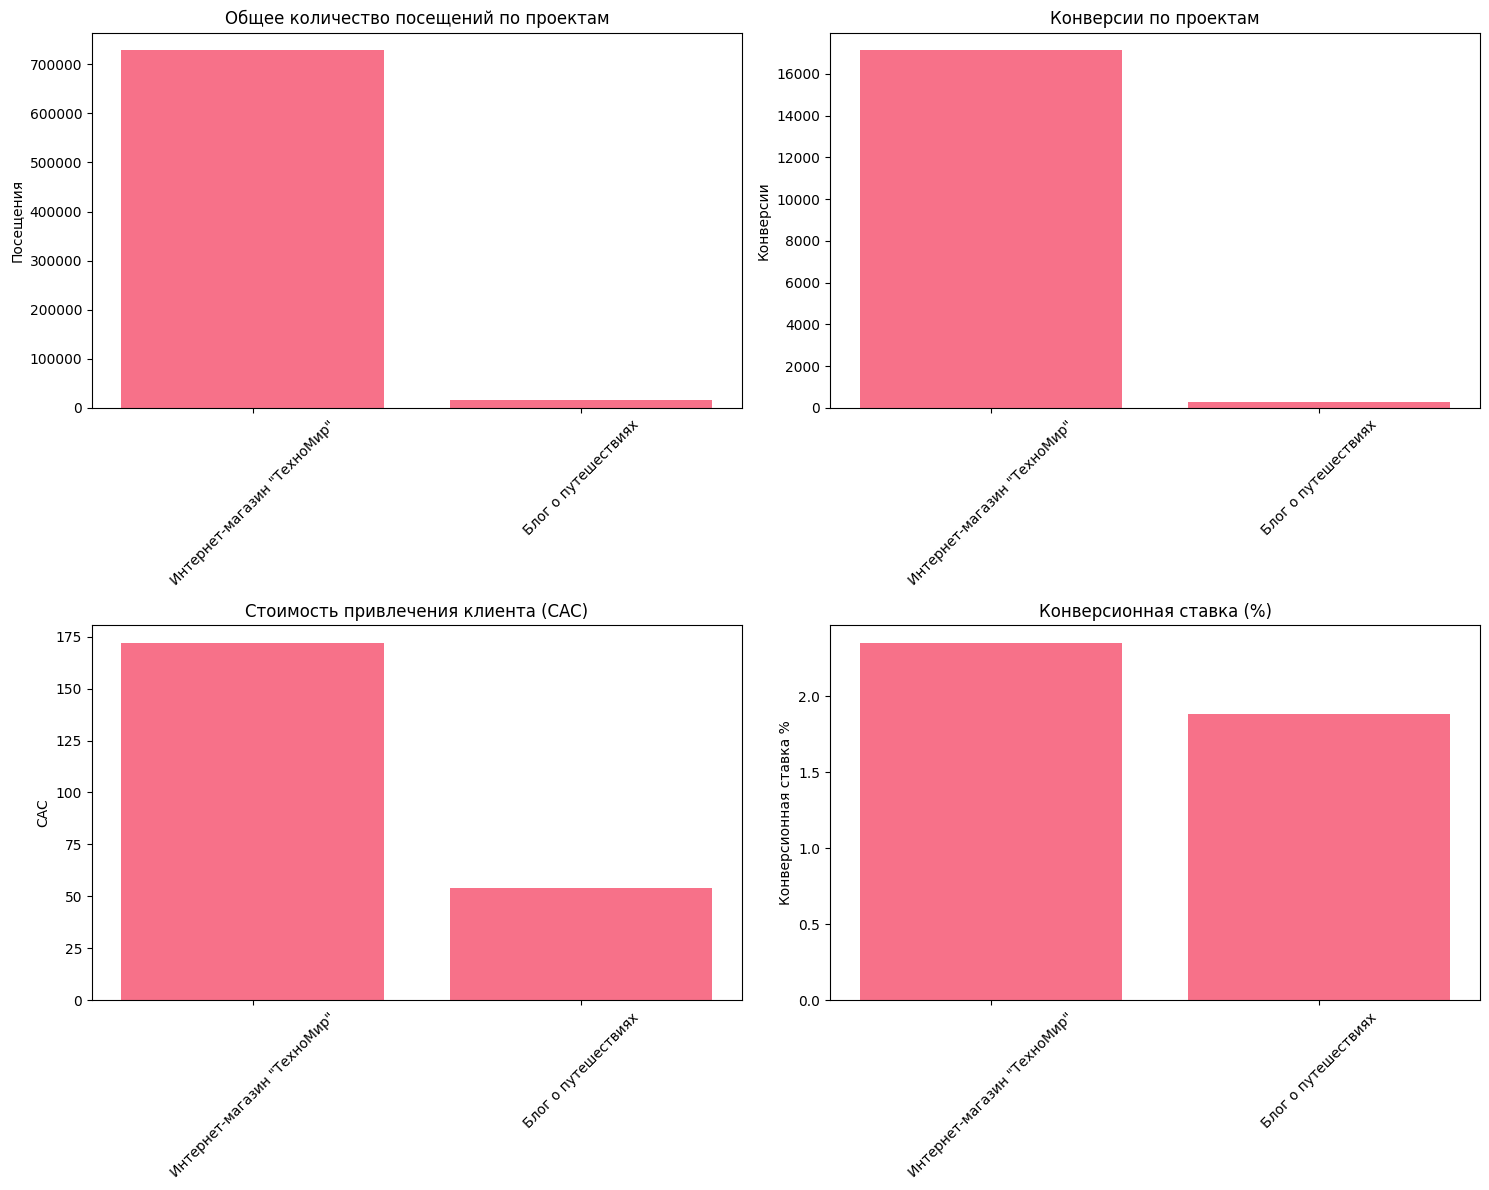


=== АНАЛИЗ ПОМЕСЯЧНЫХ ТРЕНДОВ ===
Помесячная динамика по активным проектам:
               project_name  year  month  visits  users  conversions  bounce_rate  avg_session_duration_sec  direct_cost  direct_clicks  cpc  conversion_rate  period
        Блог о путешествиях  2024      1    8000   6500          150         52.1                       120       8200.0          800.0 10.0             1.88 2024-01
Интернет-магазин "ТехноМир"  2023     12   14000  11000          300         48.2                       165      56640.0         4800.0 11.0             2.14 2023-12
Интернет-магазин "ТехноМир"  2024      1   15000  12000          350         45.5                       180      66170.0         5500.0 12.0             2.33 2024-01
Интернет-магазин "ТехноМир"  2024      2   16500  13000          420         42.3                       195          NaN            NaN  NaN             2.55 2024-02


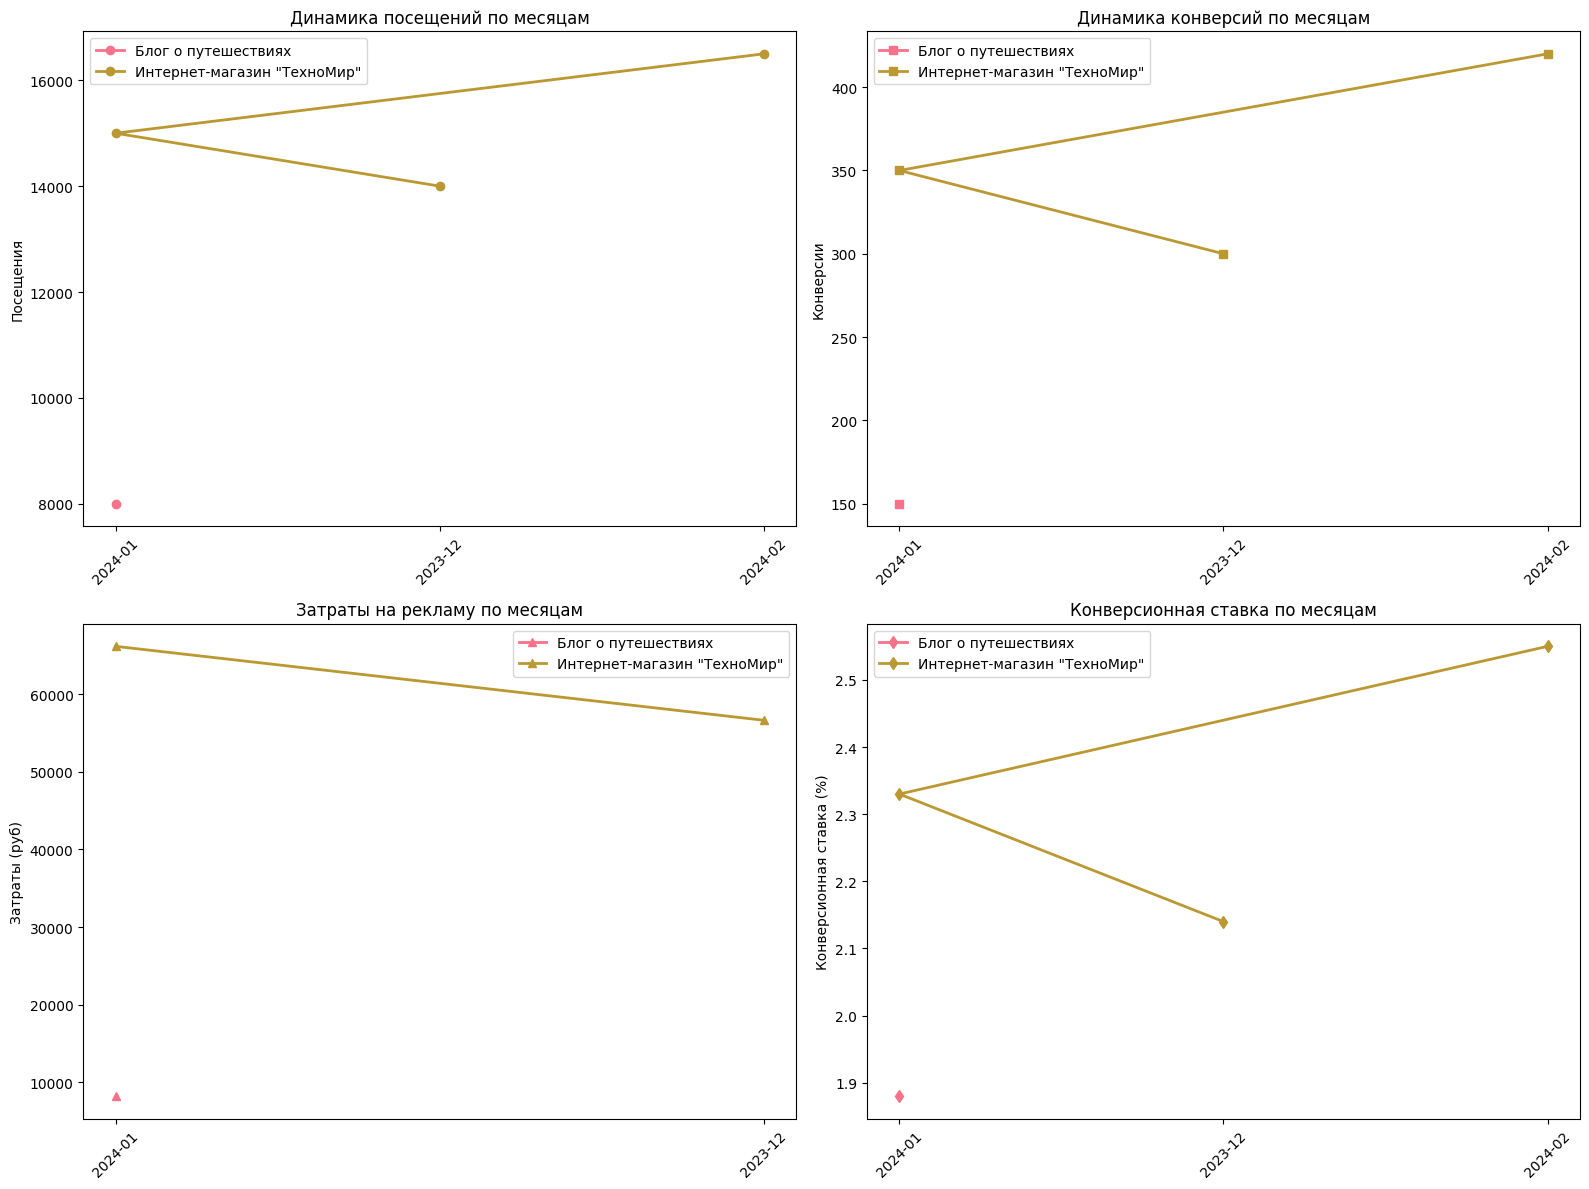


=== АНАЛИЗ ЭФФЕКТИВНОСТИ КАМПАНИЙ ДИРЕКТ ===
Эффективность кампаний за Январь 2024:
               project_name                    campaign_name status  year  month  impressions  clicks  ctr_pct   cpc  conversions    cpa  cost  conversion_rate
Интернет-магазин "ТехноМир"       Кампания - Товары для дома ACTIVE  2024      1        50000    2500     5.00 12.50          120 260.42 31250             4.80
Интернет-магазин "ТехноМир"           Кампания - Электроника PAUSED  2024      1        30000    1200     4.00 15.75           80 236.25 18900             6.67
Интернет-магазин "ТехноМир"               Мобильная кампания ACTIVE  2024      1        25000    1800     7.20  8.90           95 168.42 16020             5.28
        Блог о путешествиях Кампания - Статьи о путешествиях ACTIVE  2024      1        15000     800     5.33 10.25           45 182.22  8200             5.63


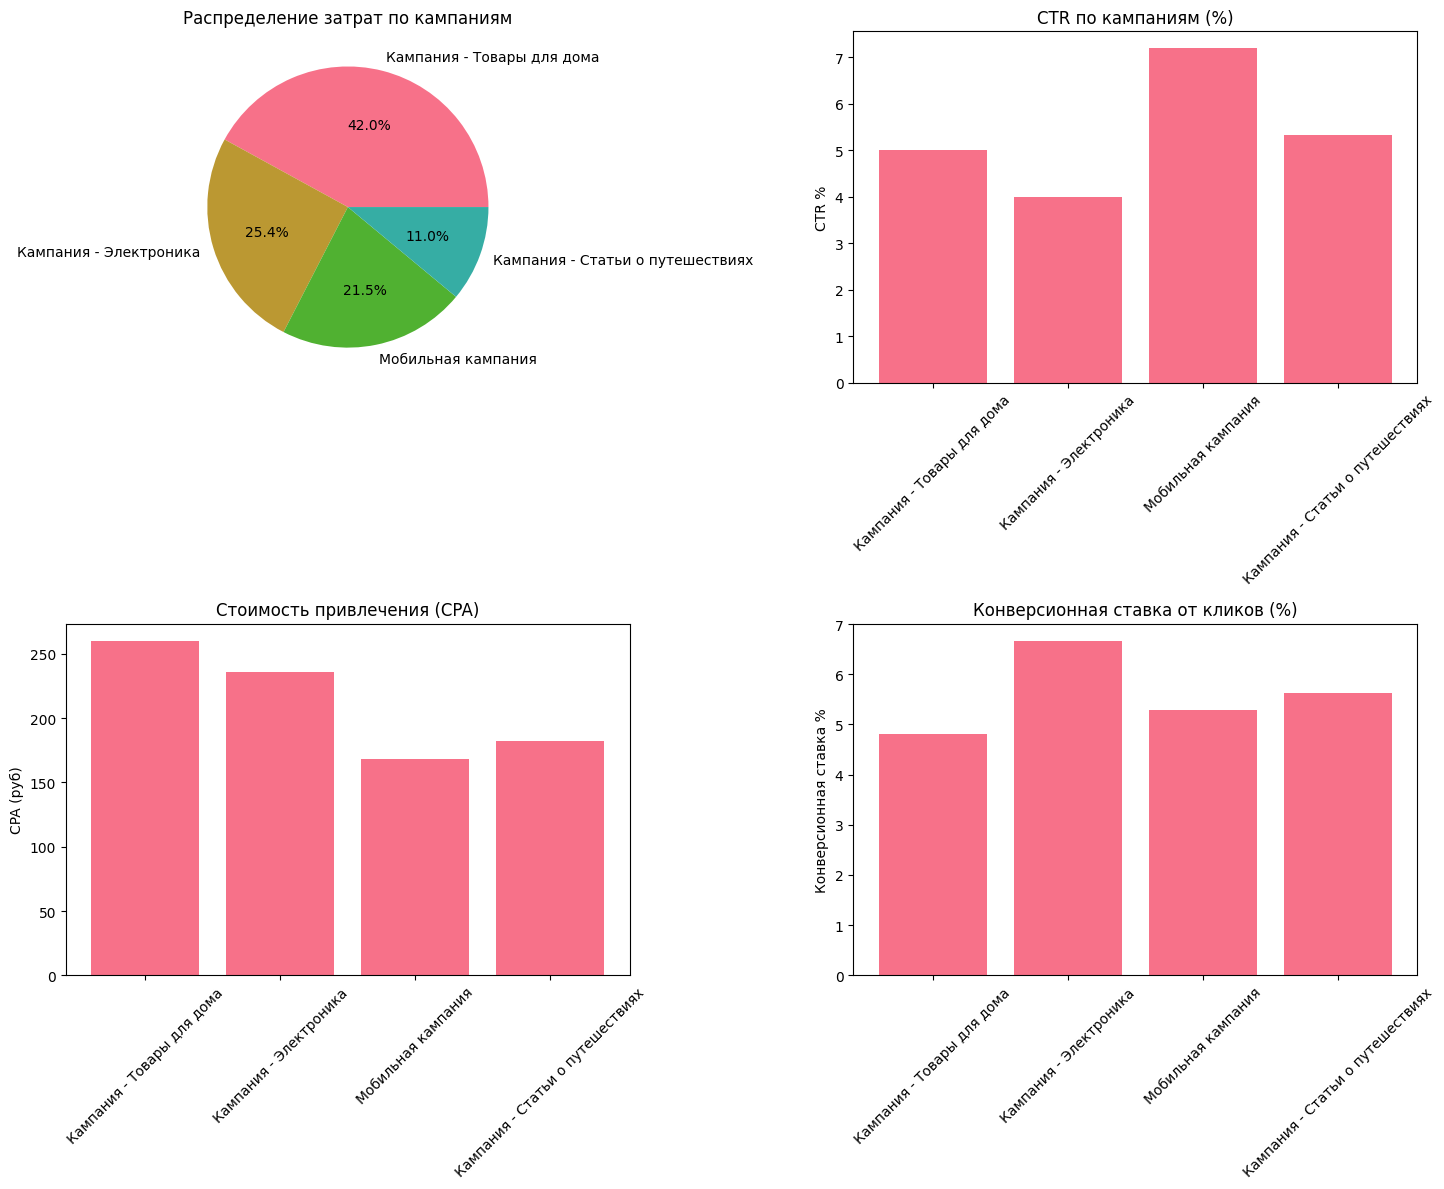


📊 КЛЮЧЕВЫЕ МЕТРИКИ КАМПАНИЙ:
Средний CTR: 5.38%
Средний CPC: 11.85 руб
Средний CPA: 211.83 руб
Средняя конверсионная ставка: 5.59%

=== АНАЛИЗ ДЕМОГРАФИИ АУДИТОРИИ ===
Демографическое распределение аудитории:
               project_name age_group  total_visits  total_users  avg_bounce_rate  avg_session_duration
Интернет-магазин "ТехноМир"     25-34          6000         4800             40.1                 210.0
Интернет-магазин "ТехноМир"     35-44          4000         3200             38.5                 195.0
Интернет-магазин "ТехноМир"     18-24          3000         2500             55.2                 150.0
Интернет-магазин "ТехноМир"     45-54          1500         1200             42.3                 180.0
Интернет-магазин "ТехноМир"       55+           500          400             50.1                 160.0


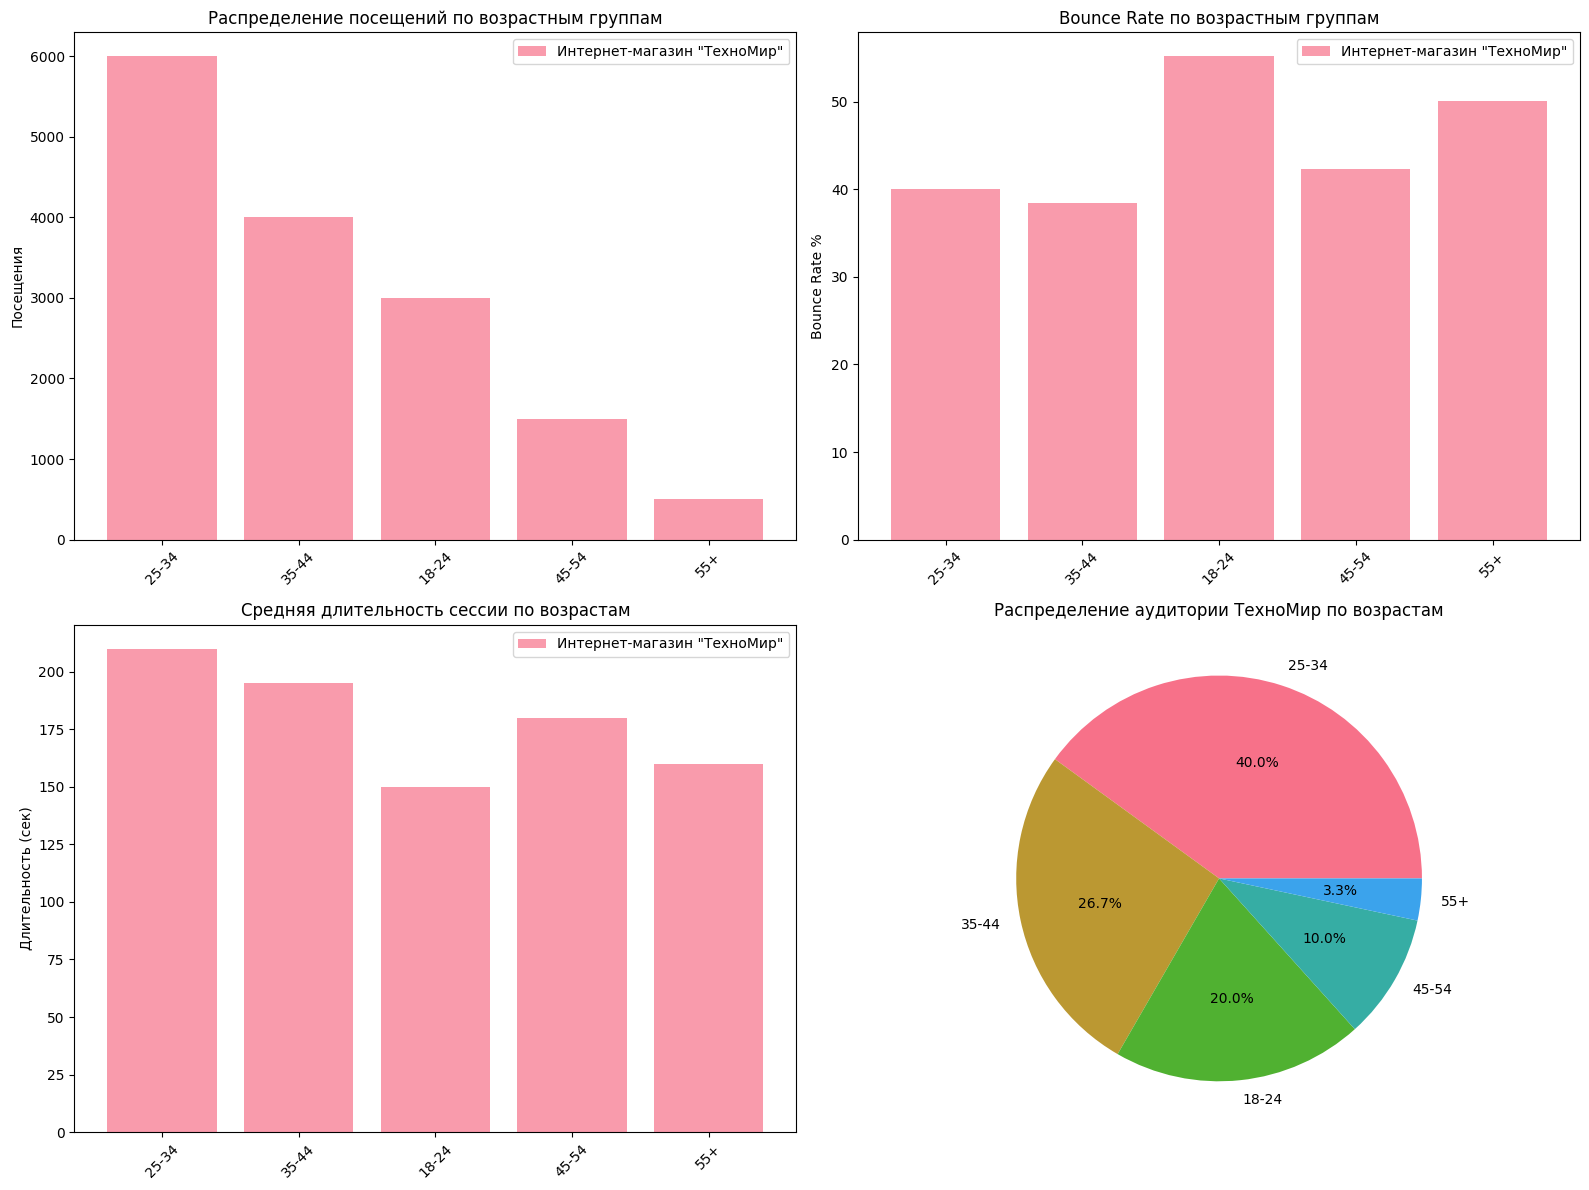


=== АНАЛИЗ SEO ЭФФЕКТИВНОСТИ ===
SEO позиции по запросам:
               project_name                        query  position  year  month
        Блог о путешествиях лучшие места для путешествий         2  2024      1
        Блог о путешествиях              советы туристам         4  2024      1
Интернет-магазин "ТехноМир"               купить ноутбук         3  2024      1
Интернет-магазин "ТехноМир"            игровой компьютер         5  2024      1
Интернет-магазин "ТехноМир"                смартфон цена         8  2024      1
Интернет-магазин "ТехноМир"               купить ноутбук         2  2024      2

📊 АНАЛИЗ ДИНАМИКИ SEO ПОЗИЦИЙ:
                                                         position           \
                                                              min max mean   
project_name                query                                            
Блог о путешествиях         лучшие места для путешествий        2   2  2.0   
                            советы ту

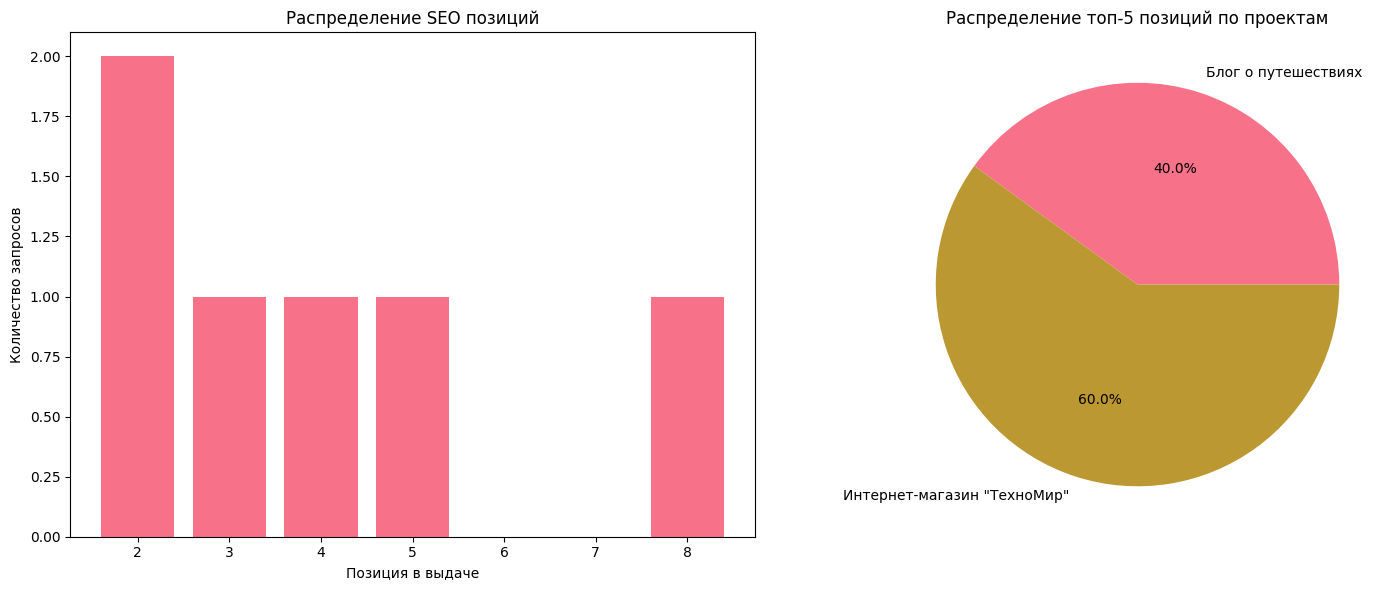


🎯 КЛЮЧЕВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ
📈 ОБЩАЯ СТАТИСТИКА:
   • Всего посещений: 744,000
   • Всего конверсий: 17,420
   • Общие затраты на рекламу: 2,963,840.00 руб
   • Средняя конверсионная ставка: 2.12%
   • CAC (в среднем): 113.00 руб

🏆 САМЫЙ УСПЕШНЫЙ ПРОЕКТ: Интернет-магазин "ТехноМир"
   • Посещения: 728,000
   • Конверсии: 17,120
   • Конверсионная ставка: 2.35%

⚠️  ПРОЕКТ ТРЕБУЮЩИЙ ВНИМАНИЯ: Блог о путешествиях
   • Посещения: 16,000
   • Конверсии: 300

💡 РЕКОМЕНДАЦИИ:

🎉 Анализ завершен! Все отчеты и графики сгенерированы.


In [30]:

# Настройка отображения графиков
plt.style.use('default')
sns.set_palette("husl")

class ProjectAnalytics:
    def __init__(self, db_file='project_analytics_complete.db'):
        self.db_file = db_file
        self.conn = sqlite3.connect(db_file)
        
    def close(self):
        """Закрывает соединение с базой"""
        self.conn.close()
    
    def get_basic_stats(self):
        """Основная статистика по базе данных"""
        print("=== ОСНОВНАЯ СТАТИСТИКА БАЗЫ ДАННЫХ ===")
        
        # Статистика по таблицам
        tables_query = """
        SELECT name FROM sqlite_master 
        WHERE type='table' AND name NOT LIKE 'sqlite_%'
        ORDER BY name
        """
        tables = pd.read_sql_query(tables_query, self.conn)
        
        stats = []
        for table in tables['name']:
            count_query = f"SELECT COUNT(*) as count FROM {table}"
            count_df = pd.read_sql_query(count_query, self.conn)
            stats.append({
                'Таблица': table,
                'Записей': count_df['count'].iloc[0]
            })
        
        stats_df = pd.DataFrame(stats)
        print(stats_df.to_string(index=False))
        print(f"\nВсего таблиц: {len(stats_df)}")
        print(f"Всего записей: {stats_df['Записей'].sum()}")
        
        return stats_df
    
    def analyze_projects_performance(self):
        """Анализ производительности проектов"""
        print("\n=== АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ ПРОЕКТОВ ===")
        
        query = """
        SELECT 
            p.name as project_name,
            p.currency,
            p.is_active,
            COUNT(DISTINCT yc.id) as counters_count,
            COUNT(DISTINCT g.id) as goals_count,
            COUNT(DISTINCT da.id) as direct_accounts_count,
            SUM(mm.visits) as total_visits,
            SUM(mm.users) as total_users,
            SUM(mm.conversions) as total_conversions,
            SUM(dtm.cost) as total_direct_cost,
            ROUND(SUM(dtm.cost) / NULLIF(SUM(mm.conversions), 0), 2) as cac,
            ROUND(SUM(mm.conversions) * 100.0 / NULLIF(SUM(mm.visits), 0), 2) as conversion_rate
        FROM projects p
        LEFT JOIN yandex_counters yc ON p.id = yc.project_id
        LEFT JOIN goals g ON yc.id = g.counter_id
        LEFT JOIN direct_accounts da ON p.id = da.project_id
        LEFT JOIN metrics_monthly mm ON p.id = mm.project_id
        LEFT JOIN direct_totals_monthly dtm ON p.id = dtm.project_id
        GROUP BY p.id, p.name, p.currency, p.is_active
        ORDER BY total_visits DESC
        """
        
        df = pd.read_sql_query(query, self.conn)
        print(df.to_string(index=False))
        
        # Визуализация
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # График 1: Посещения по проектам
        visits_data = df[df['total_visits'] > 0]
        axes[0, 0].bar(visits_data['project_name'], visits_data['total_visits'])
        axes[0, 0].set_title('Общее количество посещений по проектам')
        axes[0, 0].set_ylabel('Посещения')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # График 2: Конверсии по проектам
        conversions_data = df[df['total_conversions'] > 0]
        axes[0, 1].bar(conversions_data['project_name'], conversions_data['total_conversions'])
        axes[0, 1].set_title('Конверсии по проектам')
        axes[0, 1].set_ylabel('Конверсии')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # График 3: Стоимость привлечения (CAC)
        cac_data = df[df['cac'].notna() & (df['cac'] > 0)]
        axes[1, 0].bar(cac_data['project_name'], cac_data['cac'])
        axes[1, 0].set_title('Стоимость привлечения клиента (CAC)')
        axes[1, 0].set_ylabel('CAC')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # График 4: Конверсионная ставка
        cr_data = df[df['conversion_rate'].notna() & (df['conversion_rate'] > 0)]
        axes[1, 1].bar(cr_data['project_name'], cr_data['conversion_rate'])
        axes[1, 1].set_title('Конверсионная ставка (%)')
        axes[1, 1].set_ylabel('Конверсионная ставка %')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return df
    
    def analyze_monthly_trends(self):
        """Анализ помесячных трендов"""
        print("\n=== АНАЛИЗ ПОМЕСЯЧНЫХ ТРЕНДОВ ===")
        
        query = """
        SELECT 
            p.name as project_name,
            mm.year,
            mm.month,
            mm.visits,
            mm.users,
            mm.conversions,
            mm.bounce_rate,
            mm.avg_session_duration_sec,
            dtm.cost as direct_cost,
            dtm.clicks as direct_clicks,
            ROUND(dtm.cost / NULLIF(dtm.clicks, 0), 2) as cpc,
            ROUND(mm.conversions * 100.0 / NULLIF(mm.visits, 0), 2) as conversion_rate
        FROM metrics_monthly mm
        JOIN projects p ON mm.project_id = p.id
        LEFT JOIN direct_totals_monthly dtm ON mm.project_id = dtm.project_id 
            AND mm.year = dtm.year AND mm.month = dtm.month
        WHERE p.is_active = TRUE
        ORDER BY p.name, mm.year, mm.month
        """
        
        df = pd.read_sql_query(query, self.conn)
        df['period'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
        
        print("Помесячная динамика по активным проектам:")
        print(df.to_string(index=False))
        
        # Визуализация трендов
        projects = df['project_name'].unique()
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        for project in projects:
            project_data = df[df['project_name'] == project]
            
            # График посещений
            axes[0, 0].plot(project_data['period'], project_data['visits'], 
                           marker='o', label=project, linewidth=2)
            
            # График конверсий
            axes[0, 1].plot(project_data['period'], project_data['conversions'], 
                           marker='s', label=project, linewidth=2)
            
            # График стоимости
            if project_data['direct_cost'].notna().any():
                axes[1, 0].plot(project_data['period'], project_data['direct_cost'], 
                               marker='^', label=project, linewidth=2)
            
            # График конверсионной ставки
            axes[1, 1].plot(project_data['period'], project_data['conversion_rate'], 
                           marker='d', label=project, linewidth=2)
        
        axes[0, 0].set_title('Динамика посещений по месяцам')
        axes[0, 0].set_ylabel('Посещения')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].legend()
        
        axes[0, 1].set_title('Динамика конверсий по месяцам')
        axes[0, 1].set_ylabel('Конверсии')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].legend()
        
        axes[1, 0].set_title('Затраты на рекламу по месяцам')
        axes[1, 0].set_ylabel('Затраты (руб)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].legend()
        
        axes[1, 1].set_title('Конверсионная ставка по месяцам')
        axes[1, 1].set_ylabel('Конверсионная ставка (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
        return df
    
    def analyze_direct_campaigns(self):
        """Анализ эффективности кампаний Яндекс.Директ"""
        print("\n=== АНАЛИЗ ЭФФЕКТИВНОСТИ КАМПАНИЙ ДИРЕКТ ===")
        
        query = """
        SELECT 
            p.name as project_name,
            dc.name as campaign_name,
            dc.status,
            dcm.year,
            dcm.month,
            dcm.impressions,
            dcm.clicks,
            dcm.ctr_pct,
            dcm.cpc,
            dcm.conversions,
            dcm.cpa,
            dcm.cost,
            ROUND(dcm.conversions * 100.0 / NULLIF(dcm.clicks, 0), 2) as conversion_rate
        FROM direct_campaign_monthly dcm
        JOIN direct_campaigns dc ON dcm.direct_campaign_id = dc.id
        JOIN projects p ON dcm.project_id = p.id
        WHERE dcm.year = 2024 AND dcm.month = 1
        ORDER BY dcm.cost DESC
        """
        
        df = pd.read_sql_query(query, self.conn)
        print("Эффективность кампаний за Январь 2024:")
        print(df.to_string(index=False))
        
        # Анализ ROI
        df['roi'] = (df['conversions'] * 1000 - df['cost']) / df['cost'] * 100  # Упрощенный расчет ROI
        
        # Визуализация
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # График 1: Распределение затрат по кампаниям
        campaign_costs = df.groupby('campaign_name')['cost'].sum().sort_values(ascending=False)
        axes[0, 0].pie(campaign_costs.values, labels=campaign_costs.index, autopct='%1.1f%%')
        axes[0, 0].set_title('Распределение затрат по кампаниям')
        
        # График 2: CTR по кампаниям
        axes[0, 1].bar(df['campaign_name'], df['ctr_pct'])
        axes[0, 1].set_title('CTR по кампаниям (%)')
        axes[0, 1].set_ylabel('CTR %')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # График 3: CPA по кампаниям
        axes[1, 0].bar(df['campaign_name'], df['cpa'])
        axes[1, 0].set_title('Стоимость привлечения (CPA)')
        axes[1, 0].set_ylabel('CPA (руб)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # График 4: Конверсионная ставка
        axes[1, 1].bar(df['campaign_name'], df['conversion_rate'])
        axes[1, 1].set_title('Конверсионная ставка от кликов (%)')
        axes[1, 1].set_ylabel('Конверсионная ставка %')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Анализ эффективности
        print("\n📊 КЛЮЧЕВЫЕ МЕТРИКИ КАМПАНИЙ:")
        print(f"Средний CTR: {df['ctr_pct'].mean():.2f}%")
        print(f"Средний CPC: {df['cpc'].mean():.2f} руб")
        print(f"Средний CPA: {df['cpa'].mean():.2f} руб")
        print(f"Средняя конверсионная ставка: {df['conversion_rate'].mean():.2f}%")
        
        return df
    
    def analyze_audience_demographics(self):
        """Анализ демографии аудитории"""
        print("\n=== АНАЛИЗ ДЕМОГРАФИИ АУДИТОРИИ ===")
        
        query = """
        SELECT 
            p.name as project_name,
            mam.age_group,
            SUM(mam.visits) as total_visits,
            SUM(mam.users) as total_users,
            AVG(mam.bounce_rate) as avg_bounce_rate,
            AVG(mam.avg_session_duration_sec) as avg_session_duration
        FROM metrics_age_monthly mam
        JOIN projects p ON mam.project_id = p.id
        WHERE mam.visits > 0
        GROUP BY p.name, mam.age_group
        ORDER BY p.name, total_visits DESC
        """
        
        df = pd.read_sql_query(query, self.conn)
        print("Демографическое распределение аудитории:")
        print(df.to_string(index=False))
        
        # Визуализация
        projects = df['project_name'].unique()
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        for i, project in enumerate(projects):
            project_data = df[df['project_name'] == project]
            
            # Распределение по возрастам (посещения)
            axes[0, 0].bar(project_data['age_group'], project_data['total_visits'], 
                          alpha=0.7, label=project)
            
            # Bounce rate по возрастам
            axes[0, 1].bar(project_data['age_group'], project_data['avg_bounce_rate'], 
                          alpha=0.7, label=project)
            
            # Длительность сессии по возрастам
            axes[1, 0].bar(project_data['age_group'], project_data['avg_session_duration'], 
                          alpha=0.7, label=project)
        
        axes[0, 0].set_title('Распределение посещений по возрастным группам')
        axes[0, 0].set_ylabel('Посещения')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].legend()
        
        axes[0, 1].set_title('Bounce Rate по возрастным группам')
        axes[0, 1].set_ylabel('Bounce Rate %')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].legend()
        
        axes[1, 0].set_title('Средняя длительность сессии по возрастам')
        axes[1, 0].set_ylabel('Длительность (сек)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].legend()
        
        # Круговая диаграмма для основного проекта
        main_project_data = df[df['project_name'] == 'Интернет-магазин "ТехноМир"']
        axes[1, 1].pie(main_project_data['total_visits'], 
                      labels=main_project_data['age_group'], 
                      autopct='%1.1f%%')
        axes[1, 1].set_title('Распределение аудитории ТехноМир по возрастам')
        
        plt.tight_layout()
        plt.show()
        
        return df
    
    def analyze_seo_performance(self):
        """Анализ SEO эффективности"""
        print("\n=== АНАЛИЗ SEO ЭФФЕКТИВНОСТИ ===")
        
        query = """
        SELECT 
            p.name as project_name,
            sqm.query,
            sqm.position,
            sqm.year,
            sqm.month
        FROM seo_queries_monthly sqm
        JOIN projects p ON sqm.project_id = p.id
        ORDER BY p.name, sqm.year, sqm.month, sqm.position
        """
        
        df = pd.read_sql_query(query, self.conn)
        print("SEO позиции по запросам:")
        print(df.to_string(index=False))
        
        # Анализ динамики позиций
        position_analysis = df.groupby(['project_name', 'query']).agg({
            'position': ['min', 'max', 'mean', 'last']
        }).round(2)
        
        print("\n📊 АНАЛИЗ ДИНАМИКИ SEO ПОЗИЦИЙ:")
        print(position_analysis)
        
        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Распределение позиций
        position_counts = df['position'].value_counts().sort_index()
        axes[0].bar(position_counts.index, position_counts.values)
        axes[0].set_title('Распределение SEO позиций')
        axes[0].set_xlabel('Позиция в выдаче')
        axes[0].set_ylabel('Количество запросов')
        
        # Топ запросов по проектам
        top_queries = df[df['position'] <= 5].groupby(['project_name', 'query']).size().reset_index(name='count')
        project_queries = top_queries.groupby('project_name')['count'].sum()
        axes[1].pie(project_queries.values, labels=project_queries.index, autopct='%1.1f%%')
        axes[1].set_title('Распределение топ-5 позиций по проектам')
        
        plt.tight_layout()
        plt.show()
        
        return df
    
    def generate_comprehensive_report(self):
        """Генерирует комплексный отчет"""
        print("=" * 80)
        print("📊 КОМПЛЕКСНЫЙ АНАЛИТИЧЕСКИЙ ОТЧЕТ")
        print("=" * 80)
        
        # Собираем все анализы
        basic_stats = self.get_basic_stats()
        project_performance = self.analyze_projects_performance()
        monthly_trends = self.analyze_monthly_trends()
        direct_analysis = self.analyze_direct_campaigns()
        demographics = self.analyze_audience_demographics()
        seo_analysis = self.analyze_seo_performance()
        
        # Сводка ключевых метрик
        print("\n" + "=" * 80)
        print("🎯 КЛЮЧЕВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
        print("=" * 80)
        
        total_visits = project_performance['total_visits'].sum()
        total_conversions = project_performance['total_conversions'].sum()
        total_cost = project_performance['total_direct_cost'].sum()
        avg_conversion_rate = project_performance['conversion_rate'].mean()
        
        print(f"📈 ОБЩАЯ СТАТИСТИКА:")
        print(f"   • Всего посещений: {total_visits:,.0f}")
        print(f"   • Всего конверсий: {total_conversions:,.0f}")
        print(f"   • Общие затраты на рекламу: {total_cost:,.2f} руб")
        print(f"   • Средняя конверсионная ставка: {avg_conversion_rate:.2f}%")
        print(f"   • CAC (в среднем): {project_performance['cac'].mean():.2f} руб")
        
        # Анализ эффективности проектов
        best_project = project_performance.loc[project_performance['total_visits'].idxmax()]
        worst_project = project_performance.loc[project_performance['total_visits'].idxmin()]
        
        print(f"\n🏆 САМЫЙ УСПЕШНЫЙ ПРОЕКТ: {best_project['project_name']}")
        print(f"   • Посещения: {best_project['total_visits']:,.0f}")
        print(f"   • Конверсии: {best_project['total_conversions']:,.0f}")
        print(f"   • Конверсионная ставка: {best_project['conversion_rate']:.2f}%")
        
        print(f"\n⚠️  ПРОЕКТ ТРЕБУЮЩИЙ ВНИМАНИЯ: {worst_project['project_name']}")
        print(f"   • Посещения: {worst_project['total_visits']:,.0f}")
        print(f"   • Конверсии: {worst_project['total_conversions']:,.0f}")
        
        # Рекомендации
        print(f"\n💡 РЕКОМЕНДАЦИИ:")
        if direct_analysis['cpa'].mean() > 1000:
            print("   • Высокий CPA - оптимизируйте таргетинг и креативы")
        if demographics['avg_bounce_rate'].mean() > 50:
            print("   • Высокий bounce rate - улучшайте пользовательский опыт")
        if seo_analysis['position'].mean() > 10:
            print("   • Низкие SEO позиции - усильте SEO оптимизацию")
        
        return {
            'basic_stats': basic_stats,
            'project_performance': project_performance,
            'monthly_trends': monthly_trends,
            'direct_analysis': direct_analysis,
            'demographics': demographics,
            'seo_analysis': seo_analysis
        }

# Использование анализатора
def run_complete_analysis():
    """Запускает полный анализ базы данных"""
    analyzer = ProjectAnalytics()
    
    try:
        report = analyzer.generate_comprehensive_report()
        return report
    finally:
        analyzer.close()

# Запуск анализа
print("Запускаем комплексный анализ базы данных...")
report = run_complete_analysis()

print("\n🎉 Анализ завершен! Все отчеты и графики сгенерированы.")

In [31]:
def advanced_analysis():
    """Расширенный анализ с дополнительными метриками"""
    
    analyzer = ProjectAnalytics()
    
    # Анализ ROI по кампаниям
    print("\n=== РАСШИРЕННЫЙ АНАЛИЗ ROI ===")
    
    roi_query = """
    SELECT 
        p.name as project_name,
        dc.name as campaign_name,
        dcm.cost,
        dcm.conversions,
        CASE 
            WHEN dcm.conversions > 0 THEN ROUND((dcm.conversions * 1000 - dcm.cost) / dcm.cost * 100, 2)
            ELSE 0 
        END as roi_pct,
        ROUND(dcm.cost / NULLIF(dcm.conversions, 0), 2) as cpa
    FROM direct_campaign_monthly dcm
    JOIN direct_campaigns dc ON dcm.direct_campaign_id = dc.id
    JOIN projects p ON dcm.project_id = p.id
    WHERE dcm.cost > 0
    ORDER BY roi_pct DESC
    """
    
    roi_df = pd.read_sql_query(roi_query, analyzer.conn)
    print("ROI по кампаниям:")
    print(roi_df.to_string(index=False))
    
    # Анализ сезонности
    print("\n=== АНАЛИЗ СЕЗОННОСТИ ===")
    
    seasonality_query = """
    SELECT 
        month,
        SUM(visits) as total_visits,
        SUM(conversions) as total_conversions,
        ROUND(SUM(conversions) * 100.0 / SUM(visits), 2) as conversion_rate
    FROM metrics_monthly
    GROUP BY month
    ORDER BY month
    """
    
    seasonality_df = pd.read_sql_query(seasonality_query, analyzer.conn)
    print("Сезонность по месяцам:")
    print(seasonality_df.to_string(index=False))
    
    analyzer.close()
    
    return roi_df, seasonality_df

# Запуск расширенного анализа
roi_analysis, seasonality_analysis = advanced_analysis()


=== РАСШИРЕННЫЙ АНАЛИЗ ROI ===
ROI по кампаниям:
               project_name                    campaign_name  cost  conversions  roi_pct   cpa
Интернет-магазин "ТехноМир"               Мобильная кампания 16020           95    400.0 168.0
        Блог о путешествиях Кампания - Статьи о путешествиях  8200           45    400.0 182.0
Интернет-магазин "ТехноМир"           Кампания - Электроника 18900           80    300.0 236.0
Интернет-магазин "ТехноМир"       Кампания - Товары для дома 31250          120    200.0 260.0

=== АНАЛИЗ СЕЗОННОСТИ ===
Сезонность по месяцам:
 month  total_visits  total_conversions  conversion_rate
     1         23000                500             2.17
     2         16500                420             2.55
    12         14000                300             2.14
